In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")

logs = # TO FILL
processed_log_dir = f"{logs}/resultats_11-23_processed"

save_dir = f"{processed_log_dir}/bert/"
job_file = save_dir+"/summary.csv"
energy_file = save_dir+"/energy.csv"
energy = pd.read_csv(energy_file).drop(columns=["Unnamed: 0"])

/var/folders/yq/7v824pz907x0d1tjqclbqmn80000gn/T/ipykernel_58181/279735516.py:9: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  energy = pd.read_csv(energy_file).drop(columns=["Unnamed: 0"])


In [2]:
jobs = pd.read_csv(job_file).drop(columns=["Unnamed: 0"])

In [3]:
len(jobs)

27

In [4]:
jobs.columns

Index(['job', 'energy_kWh', 'energy_joule',
       'energy_consumption_since_previous_measurement_milliJ', 'job_id',
       'file', 'sub_seed', 'sub_batch-size', 'sub_num-sample',
       'sub_target-acc', 'sub_grad_step', 'srun_start_time_ms',
       'start_time_ms', 'cmd_cpu', 'cmd_ib', 'cmd_mem', 'cmd_train_batch_size',
       'cmd_learning_rate', 'cmd_opt_lamb_beta_1', 'cmd_opt_lamb_beta_2',
       'cmd_warmup_proportion', 'cmd_warmup_steps', 'cmd_start_warmup_step',
       'cmd_max_steps', 'cmd_max_seq_length', 'cmd_max_predictions_per_seq',
       'cmd_input_dir', 'cmd_init_checkpoint',
       'cmd_train_mlm_accuracy_window_size', 'cmd_target_mlm_accuracy',
       'cmd_weight_decay_rate', 'cmd_max_samples_termination',
       'cmd_eval_iter_start_samples', 'cmd_eval_iter_samples',
       'cmd_eval_batch_size', 'cmd_eval_dir', 'cmd_output_dir',
       'cmd_dwu-num-rs-pg', 'cmd_dwu-num-ar-pg', 'training_start_time_ms',
       'train_end_time_ms', 'end_time_ms', 'epoch_nb', 'block_nb

In [5]:
jobs["total_batch_size"]=jobs["mllog_d_batch_size"]*jobs["node_nb"]*8


In [6]:
job_list = list(jobs[(jobs["sub_target-acc"]==0.72)&(jobs["sub_num-sample"]==14000000)&(jobs["node_nb"]==1)].job_id)
np.array(job_list)

array([126224, 126225, 126226, 126227, 126228, 126229, 126230, 126231,
       126232, 126233, 126234, 126235, 126236, 126237, 126238, 126239,
       126240, 126241, 126242, 126243, 126244, 126245, 126246])

In [7]:
job_list = energy.groupby(["job"]).nunique()["node"].sort_values().index

In [8]:
job_list = list(jobs[(jobs["sub_target-acc"]==0.72)&(jobs["sub_num-sample"]==14000000)&(jobs["node_nb"]==1)].job_id)
job_list

[126224,
 126225,
 126226,
 126227,
 126228,
 126229,
 126230,
 126231,
 126232,
 126233,
 126234,
 126235,
 126236,
 126237,
 126238,
 126239,
 126240,
 126241,
 126242,
 126243,
 126244,
 126245,
 126246]

In [9]:
def plot_energy_components(ax ,energy_df, node, energy_col, legend=False):
    for label, df in energy_df.groupby(["device_index"]):
        df.plot(
            x="timestamp", 
            y=energy_col, 
            ax=ax, 
            label="GPU energy "+str(label),
            )
    for label, df in energy_df.groupby(["domain", "socket"]):
        df.plot(
            x="timestamp", 
            y=energy_col, 
            ax=ax, 
            label=label,
            )
    if legend:
        ax.legend(
            bbox_to_anchor=(0.5,-0.1), 
            loc='upper center',
            fontsize=20,
            ncol=2
        )
    else:
        ax.get_legend().remove()
    ax.set_title(node)
    return ax

def plot_utilization(ax, plot_df):
    plot_df[
        (plot_df["device_index"].notna())
        
        ].plot(x="timestamp", y="global_utilization_percent", ax=ax, label="GPU utilization")
    plot_df[
        (plot_df["device_index"].notna())
        ].plot(x="timestamp", y="global_memory_percent", ax=ax, label="GPU mem utilization")
    plot_df[
        (plot_df["utilization_percent"].notna())
        ].groupby("timestamp").mean().plot(ax=ax, y="utilization_percent", label="CPU avg utilization")
    # ax.legend(
    #     bbox_to_anchor=(0.5,-0.1), 
    #     loc='upper center',
    #     fontsize=20,
    #     ncol=2
    # )
    ax.get_legend().remove()
    return ax



In [10]:
for job in job_list:   
    energy_job = energy[energy["job"]==job]
    avg_df = energy_job[["energy_consumption_since_previous_measurement_milliJ", "timestamp","device_index", "domain", "socket", "global_utilization_percent", "global_memory_percent", "utilization_percent"]].copy()
    diff_df = avg_df.groupby("timestamp").first().reset_index()[["timestamp"]].diff()
    diff_df.rename(columns={"timestamp":"diff"}, inplace=True)
    diff_df["timestamp"] = avg_df.groupby("timestamp").first().reset_index()[["timestamp"]]
    avg_df = avg_df.merge(diff_df, on="timestamp")
    avg_df["power(W)"]=avg_df["energy_consumption_since_previous_measurement_milliJ"]/avg_df["diff"]  # time in msec and energy in mJ
    avg_df["timestamp"] = (avg_df["timestamp"]-avg_df["timestamp"].min())*1e-3

In [11]:
max_y = 0
max_x = 0
for job in job_list:
    energy_df = energy[energy["job"]==job]
    max_job_energy = energy_df["energy_consumption_since_previous_measurement_milliJ"].max()
    max_job_time = energy_df["timestamp"].max() - energy_df["timestamp"].min()
    if max_y<max_job_energy:
        max_y=max_job_energy
    if max_x<max_job_time:
        max_x=max_job_time
max_x, max_y

(1453904, 315437.0)

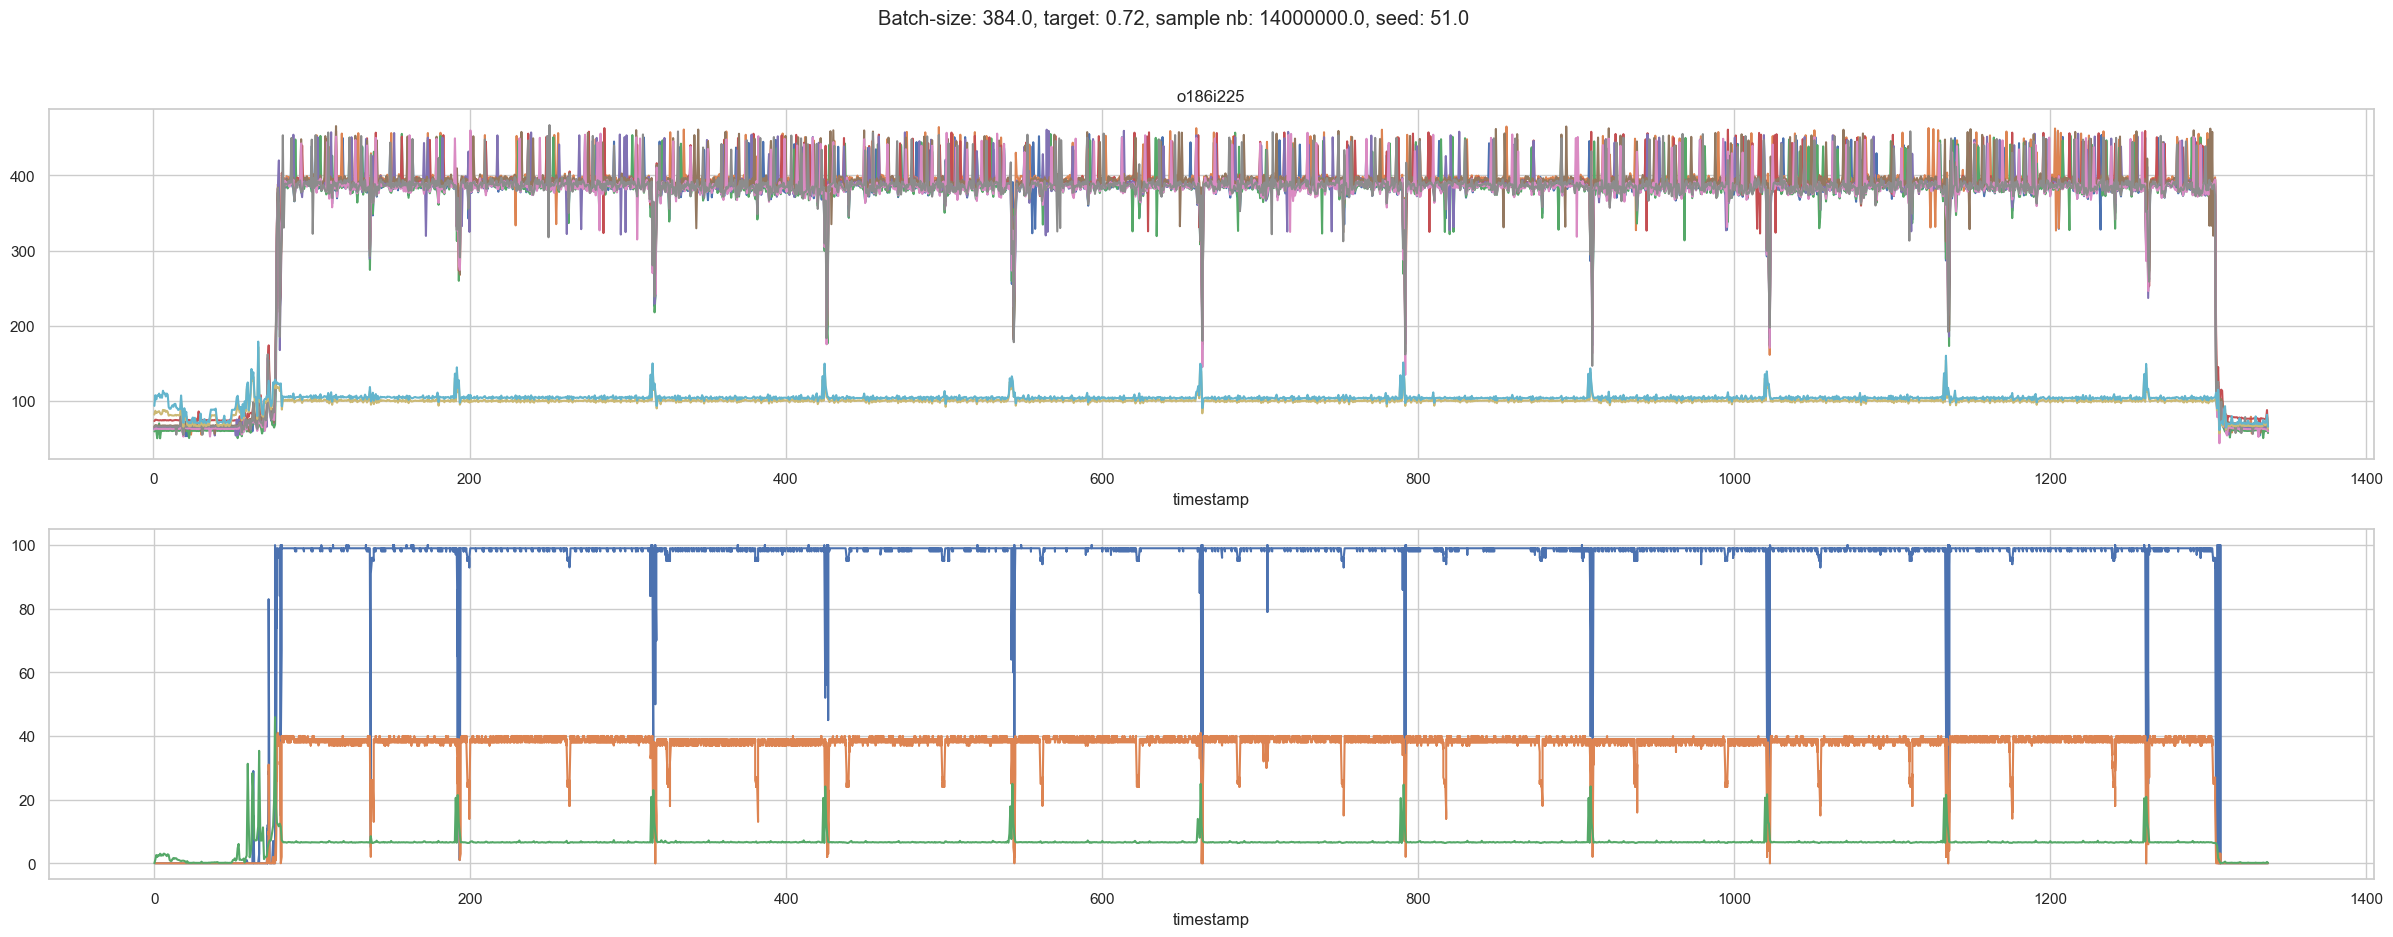

In [12]:


for job in job_list[:1]:
    energy_job = energy[energy["job"]==job]
    nodes = energy_job.node.unique()
    node_nb = len(nodes)
    batch, target, sample, seed = jobs[jobs["job"]==job][["total_batch_size", "sub_target-acc", "sub_num-sample", "sub_seed"]].values[0]
    fig, ax = plt.subplots(2, node_nb, figsize=(30,10))
    for i, node in enumerate(nodes):
        
        ax1 = ax[0,i] if node_nb>1 else ax[0]
        ax2 = ax[1,i] if node_nb>1 else ax[1]
        plot_df = energy_job[energy_job["node"]==node]
        
        avg_df = plot_df[["energy_consumption_since_previous_measurement_milliJ", "timestamp", "device_index", "domain", "socket", "global_utilization_percent", "global_memory_percent", "utilization_percent"]].copy()
        diff_df = avg_df.groupby("timestamp").first().reset_index()[["timestamp"]].diff()
        diff_df.rename(columns={"timestamp":"diff"}, inplace=True)
        diff_df["timestamp"] = avg_df.groupby("timestamp").first().reset_index()[["timestamp"]]
        avg_df = avg_df.merge(diff_df, on="timestamp")
        avg_df["power(W)"]=avg_df["energy_consumption_since_previous_measurement_milliJ"]/avg_df["diff"]  # time in msec
        avg_df["timestamp"] = (avg_df["timestamp"]-avg_df["timestamp"].min())*1e-3

        ax1 = plot_energy_components(ax1, avg_df, node, 'power(W)')
        # ax1.set_ylim(0, max_y*1.5)
        # ax1.set_xlim(-max_x*1e-3*0.01, max_x*1e-3*1.01)
        ax2 = plot_utilization(ax2, avg_df)
        # ax2.set_xlim(-max_x*1e-3*0.01, max_x*1e-3*1.01)
    plt.suptitle(f"Batch-size: {batch}, target: {target}, sample nb: {sample}, seed: {seed}")

In [13]:
# Let's

# Let's aggregate the results


<!-- avg_df = plot_df[["energy_consumption_since_previous_measurement_milliJ", "timestamp", "device_index", "domain", "socket", "global_utilization_percent", "global_memory_percent", "utilization_percent"]].copy()
diff_df = avg_df.groupby("timestamp").first().reset_index()[["timestamp"]].diff()
diff_df.rename(columns={"timestamp":"diff"}, inplace=True)
diff_df["timestamp"] = avg_df.groupby("timestamp").first().reset_index()[["timestamp"]]
avg_df = avg_df.merge(diff_df, on="timestamp")
avg_df["power(W)"]=avg_df["energy_consumption_since_previous_measurement_milliJ"]/avg_df["diff"]  # time in msec
avg_df["timestamp"] = (avg_df["timestamp"]-avg_df["timestamp"].min())*1e-3 -->

   

In [14]:
energy.describe()

,timestamp,device_index,energy_consumption_since_previous_measurement_milliJ,instantaneous_power_milliW,global_utilization_percent,global_memory_percent,job,socket,utilization_percent,energy_joule,energy_kWh,timestamps_msec
count,8.377118e+06,485400.00000,606750.000000,485400.000000,485400.000000,485400.000000,8.377118e+06,121350.000000,7.770368e+06,606750.000000,606750.000000,8.377118e+06
mean,1.699337e+12,3.50000,186607.596577,356012.294244,89.543846,33.363197,1.263194e+05,0.500000,6.559677e+00,186.607597,0.000052,5.757758e+05
std,8.548461e+07,2.29129,80496.269631,104996.934225,28.080785,11.100231,1.882053e+02,0.500002,1.916146e+01,80.496270,0.000022,3.842486e+05
min,1.699269e+12,0.00000,30027.000000,59321.000000,0.000000,0.000000,1.262240e+05,0.000000,0.000000e+00,30.027000,0.000008,-5.252100e+04
25%,1.699296e+12,1.75000,64867.637634,350738.000000,98.000000,35.000000,1.262300e+05,0.000000,0.000000e+00,64.867638,0.000018,2.489250e+05
50%,1.699306e+12,3.50000,233441.000000,402897.000000,99.000000,37.000000,1.262370e+05,0.500000,0.000000e+00,233.441000,0.000065,5.483950e+05
75%,1.699315e+12,5.25000,236923.000000,416756.000000,99.000000,39.000000,1.262440e+05,1.000000,0.000000e+00,236.923000,0.000066,8.897390e+05
max,1.699526e+12,7.00000,315437.000000,492758.000000,100.000000,43.000000,1.267400e+05,1.000000,1.000000e+02,315.437000,0.000088,1.402308e+06


In [15]:
power = pd.DataFrame()
for job in job_list[-10:]:
    power_job = pd.DataFrame()
    energy_job = energy[energy["job"]==job]
    ecol = "energy_consumption_since_previous_measurement_milliJ"
    
    power_job = energy_job[energy_job[ecol].notna()].groupby("timestamp").sum()[[ecol, "job"]].reset_index()
    power_job["timestamp(sec)"] = (power_job["timestamp"]-power_job["timestamp"].min())*1e-3
    power_job["power(W)"]=power_job[ecol]*1e-3/power_job["timestamp(sec)"].diff()
    
    power = pd.concat([power, power_job])


In [16]:
power

,timestamp,energy_consumption_since_previous_measurement_milliJ,job,timestamp(sec),power(W)
0,1699304749082,457938.081177,1262370,0.000,NaN
1,1699304749681,411290.432617,1262370,0.599,686.628435
2,1699304750282,428283.694214,1262370,1.200,712.618460
3,1699304750885,426182.160400,1262370,1.803,706.769752
4,1699304751491,433804.813843,1262370,2.409,715.849528
...,...,...,...,...,...
1955,1699318453147,397585.972656,1262460,1196.266,662.643288
1956,1699318453750,398550.637451,1262460,1196.869,660.946331
1957,1699318454346,397464.689941,1262460,1197.465,666.887064
1958,1699318454943,433878.555054,1262460,1198.062,726.764749


/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1500x800 with 0 Axes>

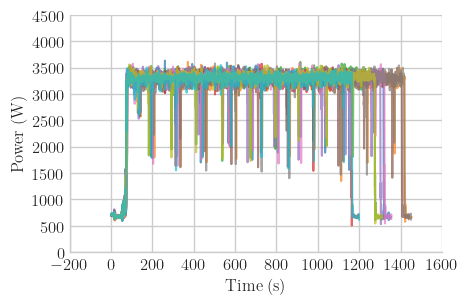

In [23]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.style.use('seaborn-v0_8-whitegrid')

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

plt.figure(figsize=(15,8))
ax = sns.relplot(
    x="timestamp(sec)", 
    y="power(W)", 
    data=power.reset_index(), 
    hue="job", kind="line", 
    palette="tab10",
    height=3, aspect=12/8,alpha=0.7,
    )
# ax.set(title="Power consumption of dlrm training")
ax._legend.remove()
FONTSIZE = 12
ax.set(ylim=(0, 4500))
ax.set_xlabels("Time (s)", fontsize=FONTSIZE)
ax.set_ylabels("Power (W)", fontsize=FONTSIZE)
ax.set_xticklabels(fontsize=FONTSIZE)
ax.set_yticklabels(fontsize=FONTSIZE)
graph_dir = "/Users/mathildepro/Documents/code_projects/hpe_logs/graphs/power"
ax.savefig(f"{graph_dir}/bert.png", dpi=300)

In [18]:
power = pd.DataFrame()
ilo_power = pd.DataFrame()
for job in job_list[-10:]:
    power_job = pd.DataFrame()
    energy_job = energy[energy["job"]==job]
    ecol = "energy_consumption_since_previous_measurement_milliJ"
    
    power_job = energy_job[energy_job[ecol].notna()].groupby("timestamp").sum()[[ecol, "job"]].reset_index()
    power_job["timestamp(sec)"] = (power_job["timestamp"]-power_job["timestamp"].min())*1e-3
    power_job["power(W)"]=power_job[ecol]*1e-3/power_job["timestamp(sec)"].diff()   
    
    power = pd.concat([power, power_job])
    
    ilo_path = f"/Users/mathildepro/Documents/code_projects/hpe_logs/resultats_nov/bert/{job}/o186i225/ilo_power.csv" 
    ilo = pd.read_csv(ilo_path)
    ilo["job"]=job
    ilo["timestamp(sec)"] = (ilo["timestamp"]-power_job["timestamp"].min()*1e-3)
    ilo_power = pd.concat([ilo_power, ilo]) 

In [19]:
min = 200
max = 1000
avg_power = power[(power["timestamp(sec)"]>min)&(power["timestamp(sec)"]<max)].groupby(["job"])["power(W)"].mean().reset_index()
avg_ilo_power = ilo_power[(ilo_power["timestamp(sec)"]>min)&(ilo_power["timestamp(sec)"]<max)].groupby(["job"])["power_watt"].mean().reset_index()


In [20]:
avg_power.agg(["mean", "std"])

,job,power(W)
mean,1.262415e+06,3289.696365
std,3.027650e+01,18.894868


In [21]:
avg_ilo_power.agg(["mean", "std"])

,job,power_watt
mean,126241.50000,3519.240870
std,3.02765,89.960333


[Text(0.5, 1.0, 'Power consumption of bert training')]

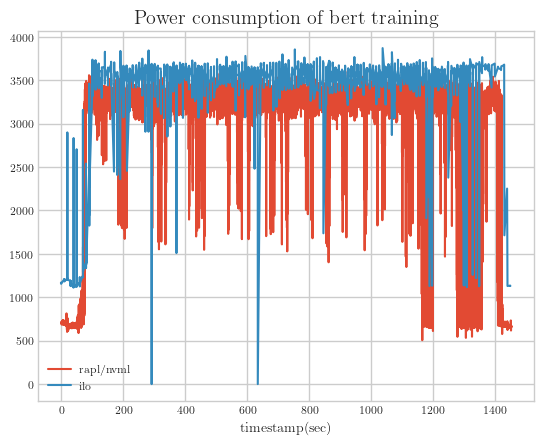

In [22]:
fig, ax = plt.subplots()
data = power.groupby(["job", "timestamp(sec)"]).mean().reset_index().sort_values(by="timestamp(sec)")
# sns.relplot(ax=ax, x="timestamp(sec)", y="power(W)", data=data, kind="line", label="rapl/nvml",height=6, aspect=15/8)
data.plot(ax=ax, x="timestamp(sec)", y="power(W)", label="rapl/nvml")
data = ilo_power.groupby(["job", "timestamp(sec)"]).mean().reset_index().sort_values(by="timestamp(sec)")
# sns.relplot(ax=ax, x="timestamp(sec)", y="power_watt", data=data, kind="line", label="ilo",height=6, aspect=15/8)
data.plot(ax=ax, x="timestamp(sec)", y="power_watt", label="ilo")
ax.set(title="Power consumption of bert training")
# ax._legend.remove()

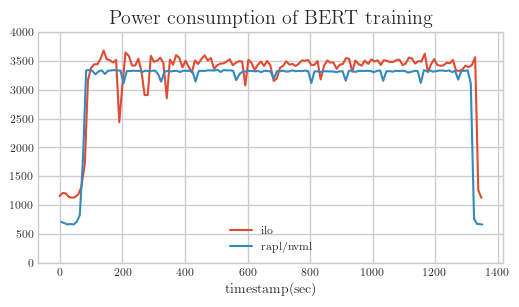

In [26]:
fig, ax = plt.subplots(figsize=(6,3))
jobid = 0

data = ilo_power[ilo_power["job"]==ilo_power["job"].values[jobid]]
data_ilo = data.set_index(pd.to_datetime(data["timestamp"], unit="s")).rename(columns={"timestamp":"coucou"}).drop(columns=["coucou"])
data_ilo.resample("10s").mean()
# data = ilo_power[ilo_power["job"]==ilo_power["job"].values[jobid]].groupby(["timestamp(sec)"]).mean().reset_index().sort_values(by="timestamp(sec)")
# sns.relplot(ax=ax, x="timestamp(sec)", y="power_watt", data=data_ilo, kind="line", label="ilo",height=6, aspect=15/8)
data_ilo.plot(ax=ax, x="timestamp(sec)", y="power_watt", label="ilo")

data = power[power["job"]==power["job"].values[jobid]]
data = data.set_index(pd.to_datetime(data["timestamp"], unit="ms")).rename(columns={"timestamp":"coucou"}).drop(columns=["coucou"])
data_power = data.resample("10s", origin=data_ilo.index[0]).mean()
# data_power = data_power.groupby(["timestamp(sec)"]).mean().reset_index().sort_values(by="timestamp(sec)") # "job", 
# sns.relplot(ax=ax, x="timestamp(sec)", y="power(W)", data=data_power, kind="line", label="rapl/nvml",height=6, aspect=15/8)
data_power.plot(ax=ax, x="timestamp(sec)", y="power(W)", label="rapl/nvml")

ax.set(title="Power consumption of BERT training")
ax.set_ylim(0, 4000)
plt.savefig(f"{graph_dir}/ilo_bert.png", dpi=300)
plt.savefig(f"{graph_dir}/ilo_bert.pdf", dpi=300)
# ax._legend.remove()